In [6]:
import sys
print(sys.executable)


d:\Tenx\acis-insurance-risk-analytics-Modeling\venv\Scripts\python.exe


In [2]:
# --- Load Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import shap

# --- Load Data ---
df = pd.read_csv('data/cleaned_insurance_data.csv')

# --- Feature Engineering ---
# Convert TransactionMonth to datetime first
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Create a 'VehicleAge' feature, as it's likely very predictive
current_year = df['TransactionMonth'].dt.year.max()
df['VehicleAge'] = current_year - df['RegistrationYear']

# --- Define Features (X) and Target (y) for Claim Severity Model ---
# The goal is to predict TotalClaims for policies that HAVE a claim
df_model = df[df['TotalClaims'] > 0].copy()

features = [
    'VehicleAge', 'CustomValueEstimate', 'kilowatts', 'cubiccapacity',
    'Province', 'VehicleType', 'make', 'bodytype', 'AlarmImmobiliser', 'TrackingDevice'
]
target = 'TotalClaims'

X = df_model[features]
y = df_model[target]

# --- Encoding Categorical Features ---
# Use one-hot encoding to convert text categories into numbers
X_encoded = pd.get_dummies(X, columns=[
    'Province', 'VehicleType', 'make', 'bodytype',
    'AlarmImmobiliser', 'TrackingDevice'
], drop_first=True)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# --- Scaling Numerical Features ---
# Important to do this AFTER the split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation for modeling is complete.")


Data preparation for modeling is complete.


In [3]:
# --- Model Building ---
# We will test three models: Linear Regression, Random Forest, and XGBoost

# 1. Linear Regression (Baseline)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# 3. XGBoost (Often the best performer)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

# --- Model Evaluation Report ---
print("--- Model Performance Comparison (Predicting Claim Amount) ---")
print(f"Linear Regression | RMSE: {lr_rmse:.2f} | R-squared: {lr_r2:.2f}")
print(f"Random Forest     | RMSE: {rf_rmse:.2f} | R-squared: {rf_r2:.2f}")
print(f"XGBoost           | RMSE: {xgb_rmse:.2f} | R-squared: {xgb_r2:.2f}")

--- Model Performance Comparison (Predicting Claim Amount) ---
Linear Regression | RMSE: 38789.01 | R-squared: -0.04
Random Forest     | RMSE: 41413.85 | R-squared: -0.18
XGBoost           | RMSE: 42421.38 | R-squared: -0.24



--- Explaining the XGBoost Model with SHAP ---
SHAP Summary Plot (Feature Importance):


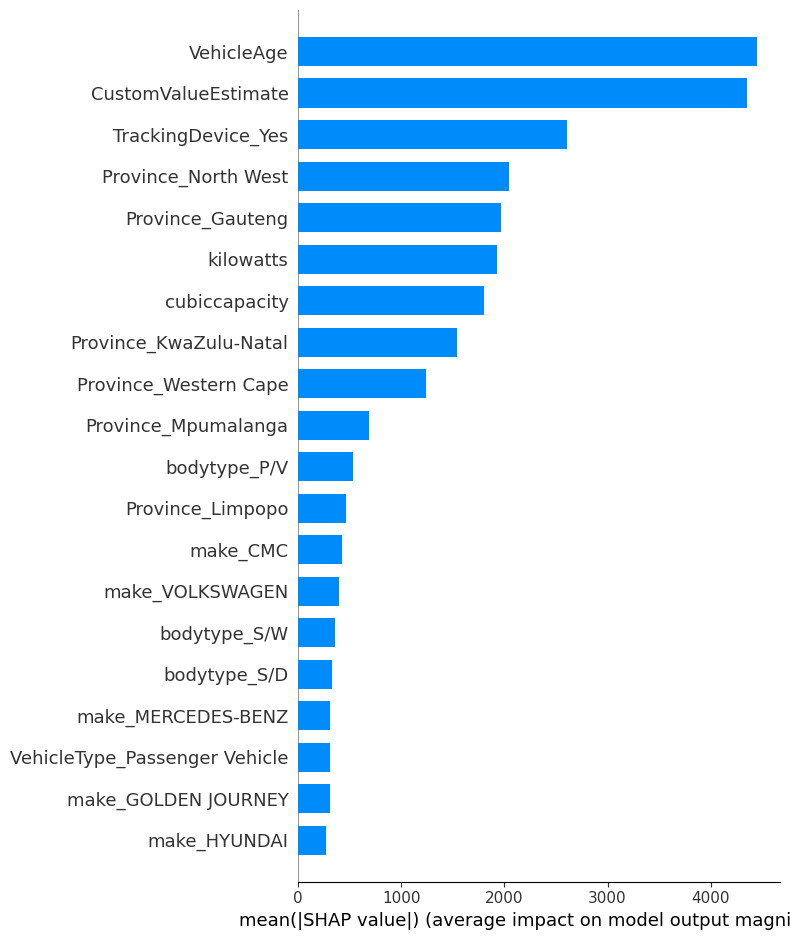


SHAP Detailed Influence Plot:


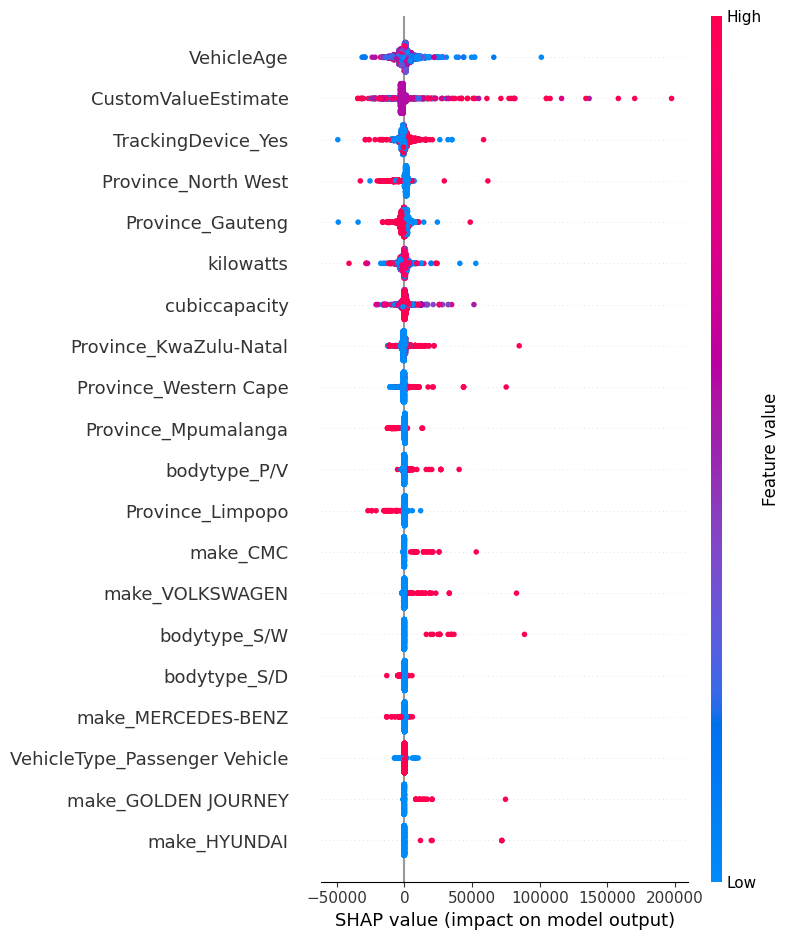

In [4]:
# --- Model Interpretability using SHAP (on the best model, e.g., XGBoost) ---
print("\n--- Explaining the XGBoost Model with SHAP ---")

# We need to get the column names back for the scaled data
X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_df)

# Plot feature importance
print("SHAP Summary Plot (Feature Importance):")
shap.summary_plot(shap_values, X_train_df, plot_type="bar")

# Plot detailed feature influence
print("\nSHAP Detailed Influence Plot:")
shap.summary_plot(shap_values, X_train_df)